<a href="https://colab.research.google.com/github/aidancrilly/MiniCourse-DifferentiableSimulation/blob/main/Solutions_01_ComputationalGraphsAndAdjointMethods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1

Resources:

- JAX [documentation](https://jax.readthedocs.io/en/latest/quickstart.html)
- B. Nikolic [blog post](https://bnikolic.co.uk/blog/python/jax/2022/02/22/jax-outputgraph-rev.html) on visualising jax graphs
- Patrick Kidger "On Neural Differential Equations" [ArXiv link](https://arxiv.org/abs/2202.02435)

In [1]:
import jax.numpy as jnp
import jax

In this exercise, we will look at computational graphs and automatic differentiaton. For this we will use Python JAX, a machine learning framework developed by Google.

To aid our understanding, we will visualise the computational graphs using the functions below. It is not important to understand exactly how this is done.

In [2]:
import pydot
from jaxlib import xla_client
from IPython.display import Image, display
import matplotlib.pyplot as plt

def view_pydot(pdot):
  plt = Image(pdot.create_png())
  display(plt)

def todotgraph(x):
  """
  Credit to: https://bnikolic.co.uk/blog/python/jax/2022/02/22/jax-outputgraph-rev.html
  """
  return xla_client._xla.hlo_module_to_dot_graph(xla_client._xla.hlo_module_from_text(x))

def viz_computational_graph(f,xs,compiled=False,static_argnums=None):
  """
  Produces a visualisation of a computational graph for function f with input x
  """
  if(compiled):
    z = jax.jit(f,static_argnums=static_argnums).lower(*xs).compile().as_text()
    z = todotgraph(z)
  else:
    z = jax.jit(f,static_argnums=static_argnums).lower(*xs).compiler_ir('hlo').as_hlo_dot_graph()
  with open("t.dot", "w") as f:
    f.write(z)
  (graph,) = pydot.graph_from_dot_file('t.dot')
  view_pydot(graph)

#Part 1

We will write a number of simple functions, use JAX's AD to differentiate them and visualise the computational graphs.

For this part of the exercise, we define 4 functions of interest:

tanh(x) : $$ \tanh(\vec{x}) = \frac{1-e^{-2\vec{x}}}{1+e^{-2\vec{x}}} $$

grad_tanh(x) : $$ \frac{d\tanh(x)}{dx} = 1 - \tanh ^2 (x) $$

log_mean_tanh(x) : $$ \text{log_mean_tanh}(\vec{x}) = \ln\left(\frac{1}{N}∑_i^N \tanh(x_i) \right)$$

grad_log_mean_tanh(x) : $$ \text{grad_log_mean_tanh}(\vec{x}) = \frac{\partial \text{log_mean_tanh}}{\partial \vec{x}}  $$

Below are a number of incomplete function defintions. Fill in the missing parts, making use of the JAX numpy library, and use viz_computational_graph to visualise their graphs.

N.B. To create the graph we need to "stage out" a specialised version of the Python function to one that operates on restricted data types (see https://jax.readthedocs.io/en/latest/aot.html for detail). To do this we must provide an argument to the function, in the following we will simple use a 1-D array of ones with length 100.

Some tips for reading the graphs:

1. Data types are explicitly given, any static operands will typically show up as f32[].
2. For binary operations, the numbers on top of the arrows into the graph node denote the position of the operand. For example, into a subtract operation the result is {Operand 0} - {Operand 1}.
3. Without compilation, the computational graphs are no necessarily optimised. When compiled, optimisations such as loop fusion will be included. While optimal, they can be less human-interpretable.

Visualise and inspect the results for each function. Some questions to ask yourself: do they make sense? For gradient operations, is there a clear extension of the original graph? How does compilation alter the graph?

First, lets start with tanh(x) and grad_tanh(x):

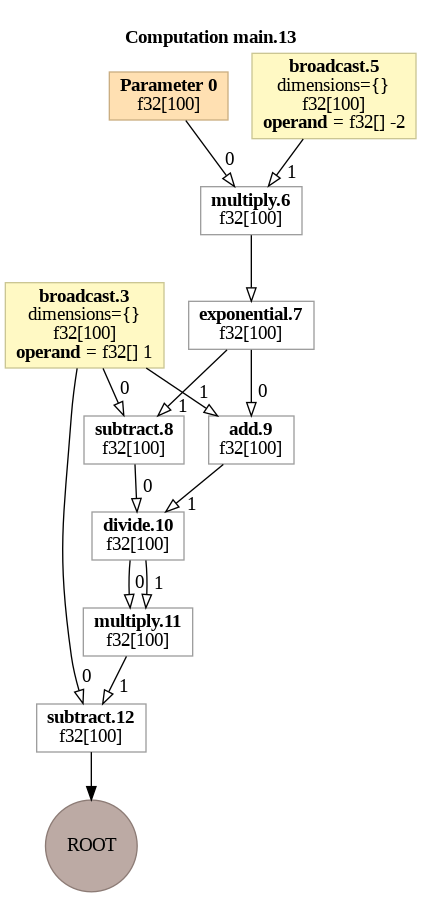

In [3]:
def tanh(x):
  """
  To be completed
  """
  y = jnp.exp(-2.0*x)
  res = (1-y)/(1+y)
  return res

def dtanh(x):
  """
  Explicit analytic derivative
  """
  res = 1-(tanh(x))**2
  return res

def grad_tanh(x):
  """
  Automatic Derivative of user defined tanh function

  N.B. jax.grad operates on scalar output functions
  we therefore need to add a jax.vmap to compute the
  derivative of every element in input x
  """
  res = jax.vmap(jax.grad(tanh))(x)
  return res

# Try visualising the computational graphs!
viz_computational_graph(dtanh,[jnp.ones(100)],compiled=False)


Check (graphically) that your analytic and automatic derivatives of tanh function agree.

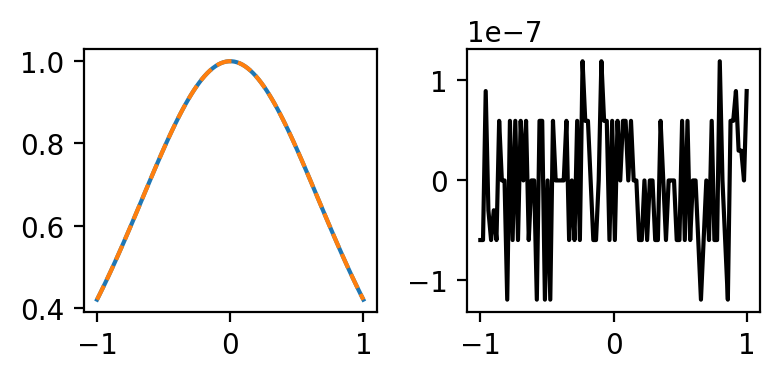

In [4]:
x = jnp.linspace(-1.0,1.0,100)

fig = plt.figure(dpi=200,figsize=(4,2))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(x,dtanh(x))
ax1.plot(x,grad_tanh(x),ls='--')

ax2.plot(x,dtanh(x)-grad_tanh(x),c='k')

fig.tight_layout()

Now, let us at look at more complex functions which take many inputs but produce a scalar output?

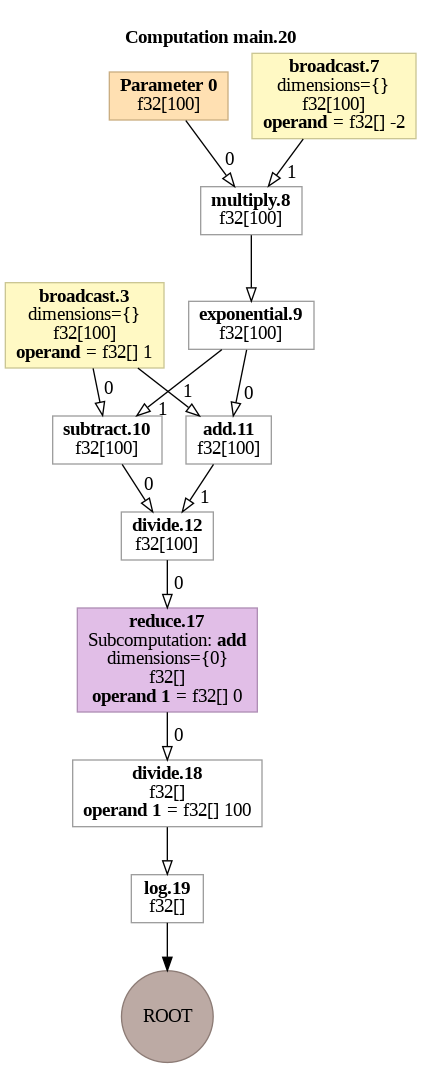

In [5]:
def log_mean_tanh(x):
  """
  To be completed
  """
  y = tanh(x)
  res = jnp.log(jnp.mean(y))
  return res

def grad_log_mean_tanh(x):
  """
  To be completed
  """
  res = jax.grad(log_mean_tanh)(x)
  return res

viz_computational_graph(log_mean_tanh,[jnp.ones(100)],compiled=False)

## Questions

1.   True or False: All the nodes in the graphs constructed above are for binary operations - i.e. have two arrows into them.
2.   The computational graphs of the autograd of tanh and an explicit analytic gradient of tanh are identical?
3. Why is the jax.vmap needed in jax.vmap(jax.grad(tanh)) but not for grad_log_mean_tanh?
4. What is the reason why the autograd and analytic gradients of tanh disagree at the 1e-7 level?
5. How are constant floats included in the graphs? What does this tell you about how the functions are compiled (hint: do you have assume something about the inputs)?

# Part 2a

We will now use the above techniques to inspect how AD computes the adjoint solution of an ODE. We will follow the example from the lecture notes, an exponential decay:

$$ \frac{dy}{dt} = - \frac{y}{\tau} $$

The simplest numerical method to solve this ODE is the Euler method. This uses the first order Taylor expansion to integrate forward in time:

$$ y^{i+1} = y^{i} - \frac{dt}{\tau} y^{i} $$

In the following exercise we will construct an Euler integrator for this ODE and use JAX AD to compute gradients through this numerical solution. We will compare the results to the analytic solutions to this problem.

In the following code block, you will write functions which define the exponential decay ODE and its analytic forward and adjoint solutions.

In [6]:
def dydt(t,y,args):
  return -y/args['tau']

def analytic_solution(y0,T,tau):
  return y0*jnp.exp(-T/tau)

def adjoint_analytic_solution(y0,y1,T,tau,loss_fn):
  dLdyT = jax.grad(loss_fn)(y1)
  return T/tau**2*dLdyT*analytic_solution(y0,T,tau)

In the following code block, you will construct the Euler numerical integrator for this problem.

In [7]:
def forward_pass_explicit_Euler(y0,t0,t1,Nt,tau,loss_fn):
  dt = (t1-t0)/(Nt)
  args = {'tau' : tau}

  def _integrate(i,yi):
    """
    Single time step using explicit Euler differencing

    y_i+1 = y_i + dydt(t_i,y_i)*dt
    """
    t = dt*i
    yip1 = yi+dydt(t,yi,args)*dt
    return yip1

  def _forward_pass():
    """
    Integrate ODE forward using for loop
    """
    y1 = jax.lax.fori_loop(0,Nt,_integrate,y0)
    L = loss_fn(y1)
    return L,y1

  return _forward_pass()

Once you are happy with your Euler integrator, run the following cell to compare your numerical solution with the analytic solution.

In [19]:
# Use very simple 'loss' function in this example
def identity(x):
  return x

tau = 0.5

t0 = 0.0
t1 = 1.0
Nt = 100

y0 = 1.0

L,y1 = forward_pass_explicit_Euler(y0,t0,t1,Nt,tau,identity)
y1_analytic = analytic_solution(y0,t1-t0,tau)
print(f'Numerical solution: {y1}, and analytic solution: {y1_analytic}')
print(f'Equivalent numerical solution: {y0*(1-(t1-t0)/Nt/tau)**Nt}')

Numerical solution: 0.13261957466602325, and analytic solution: 0.1353352814912796
Equivalent numerical solution: 0.13261955589475294


We can also visualise our ODE solver graph,

We note a couple of important features:
1. The ODE integration takes the form of a loop as expected. We have the main function which sets up the input to the loop. The internal loop which increments our $ y $ value and a counter. Finally, we have the single Euler step calculation.
2. The single Euler step is included as a subcomputation of the loop. It combines $ \tau $ and the previous loop value. As the time step has been defined in a static manner, it is included as a floating point constant in the multiply

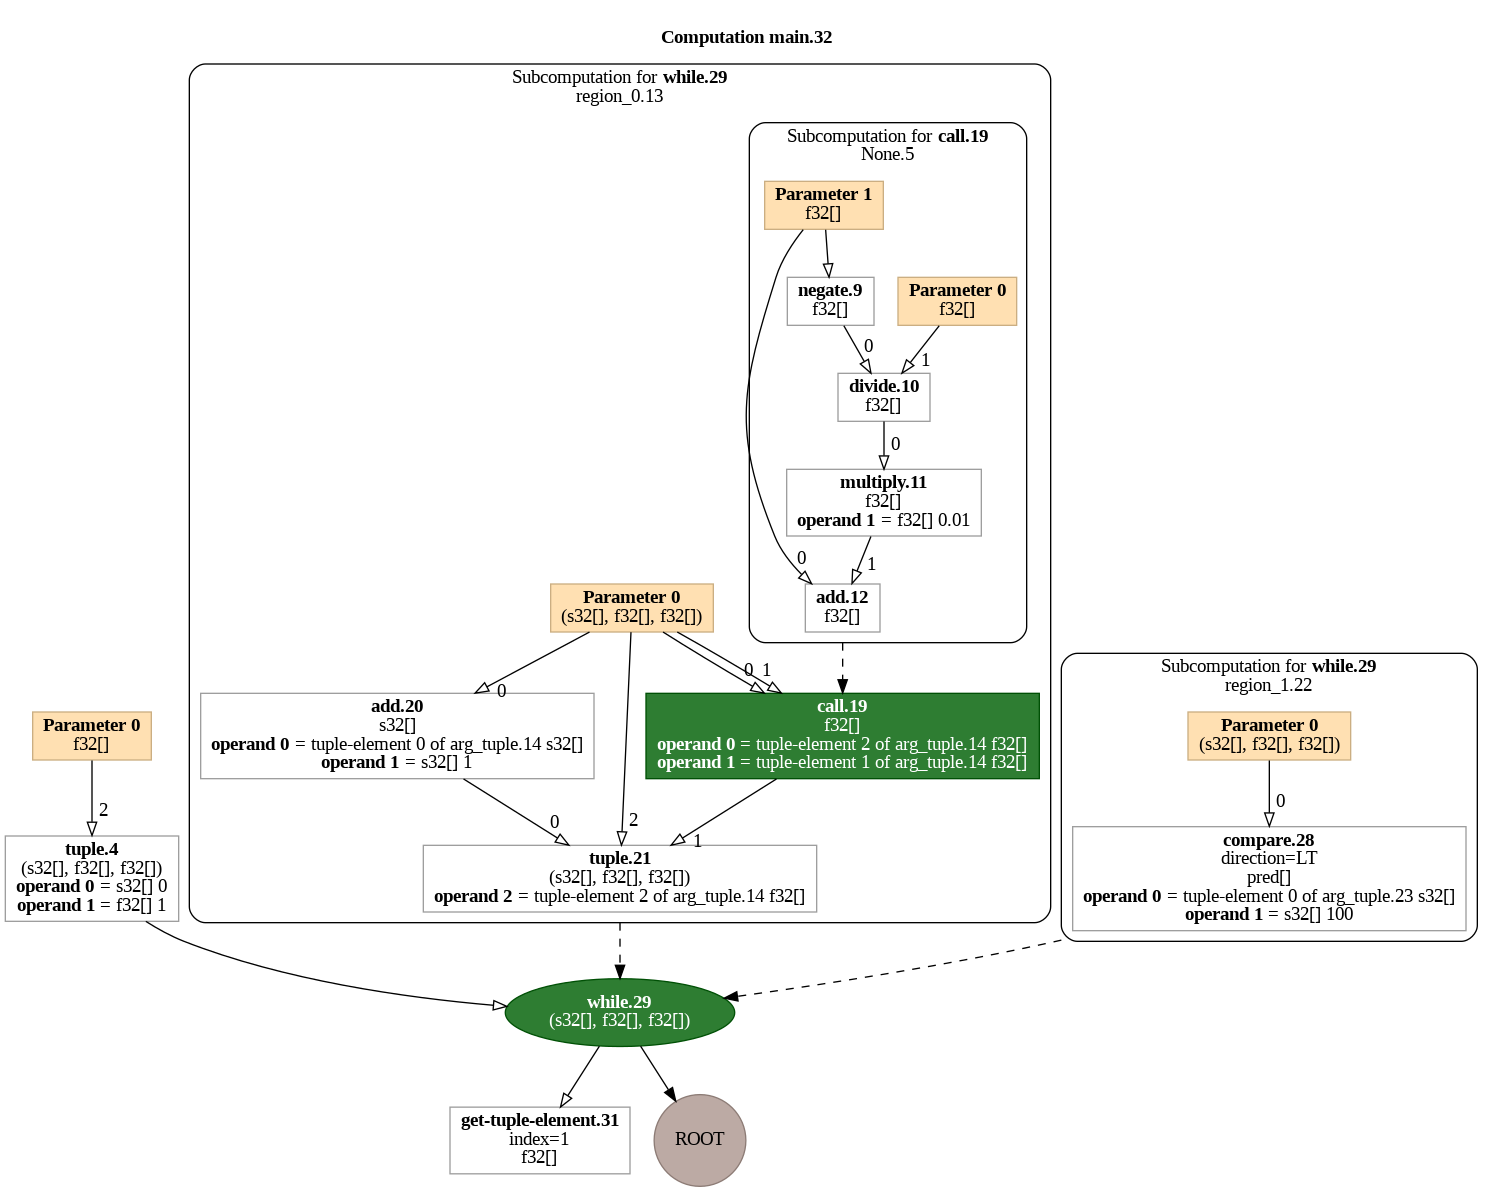

In [20]:
# One can use a lambda function to make some arguments treated as 'static'
tau_fn = lambda x : forward_pass_explicit_Euler(y0,t0,t1,Nt,x,identity)[0]
viz_computational_graph(tau_fn,[tau],compiled=False)

# Or alternatively, one can specify with static_argnums
# viz_computational_graph(forward_pass_explicit_Euler,(y0,t0,t1,Nt,tau,identity),compiled=False,static_argnums=[3,5])

We can use JAX's AD capabilities to compute the adjoint, $dL/d\tau$, based on the Euler integrator function. This is as simple as using jax.grad!

We can compare this numerical AD solution to the analytic result:

In [23]:
grad_tau_fn = jax.grad(tau_fn)
tau_adjoint_val = adjoint_analytic_solution(y0,y1,t1-t0,tau,identity)

print(f'Numerical adjoint solution: {grad_tau_fn(tau)}, and analytic adjoint solution: {tau_adjoint_val}')
print(f'Equivalent numerical solution: {y0*(t1-t0)/tau**2*(1-(t1-t0)/Nt/tau)**(Nt-1)}')

Numerical adjoint solution: 0.5413049459457397, and analytic adjoint solution: 0.5413411259651184
Equivalent numerical solution: 0.5413043097745018


The computational graph for the AD adjoint will be complex, therefore I would not recommend spending too much time looking over its details. It might be informative to identify the following:

1. The number of loops used
2. Where the Euler forward step appears
3. Whether the foward or backward solve involves more operations per loop

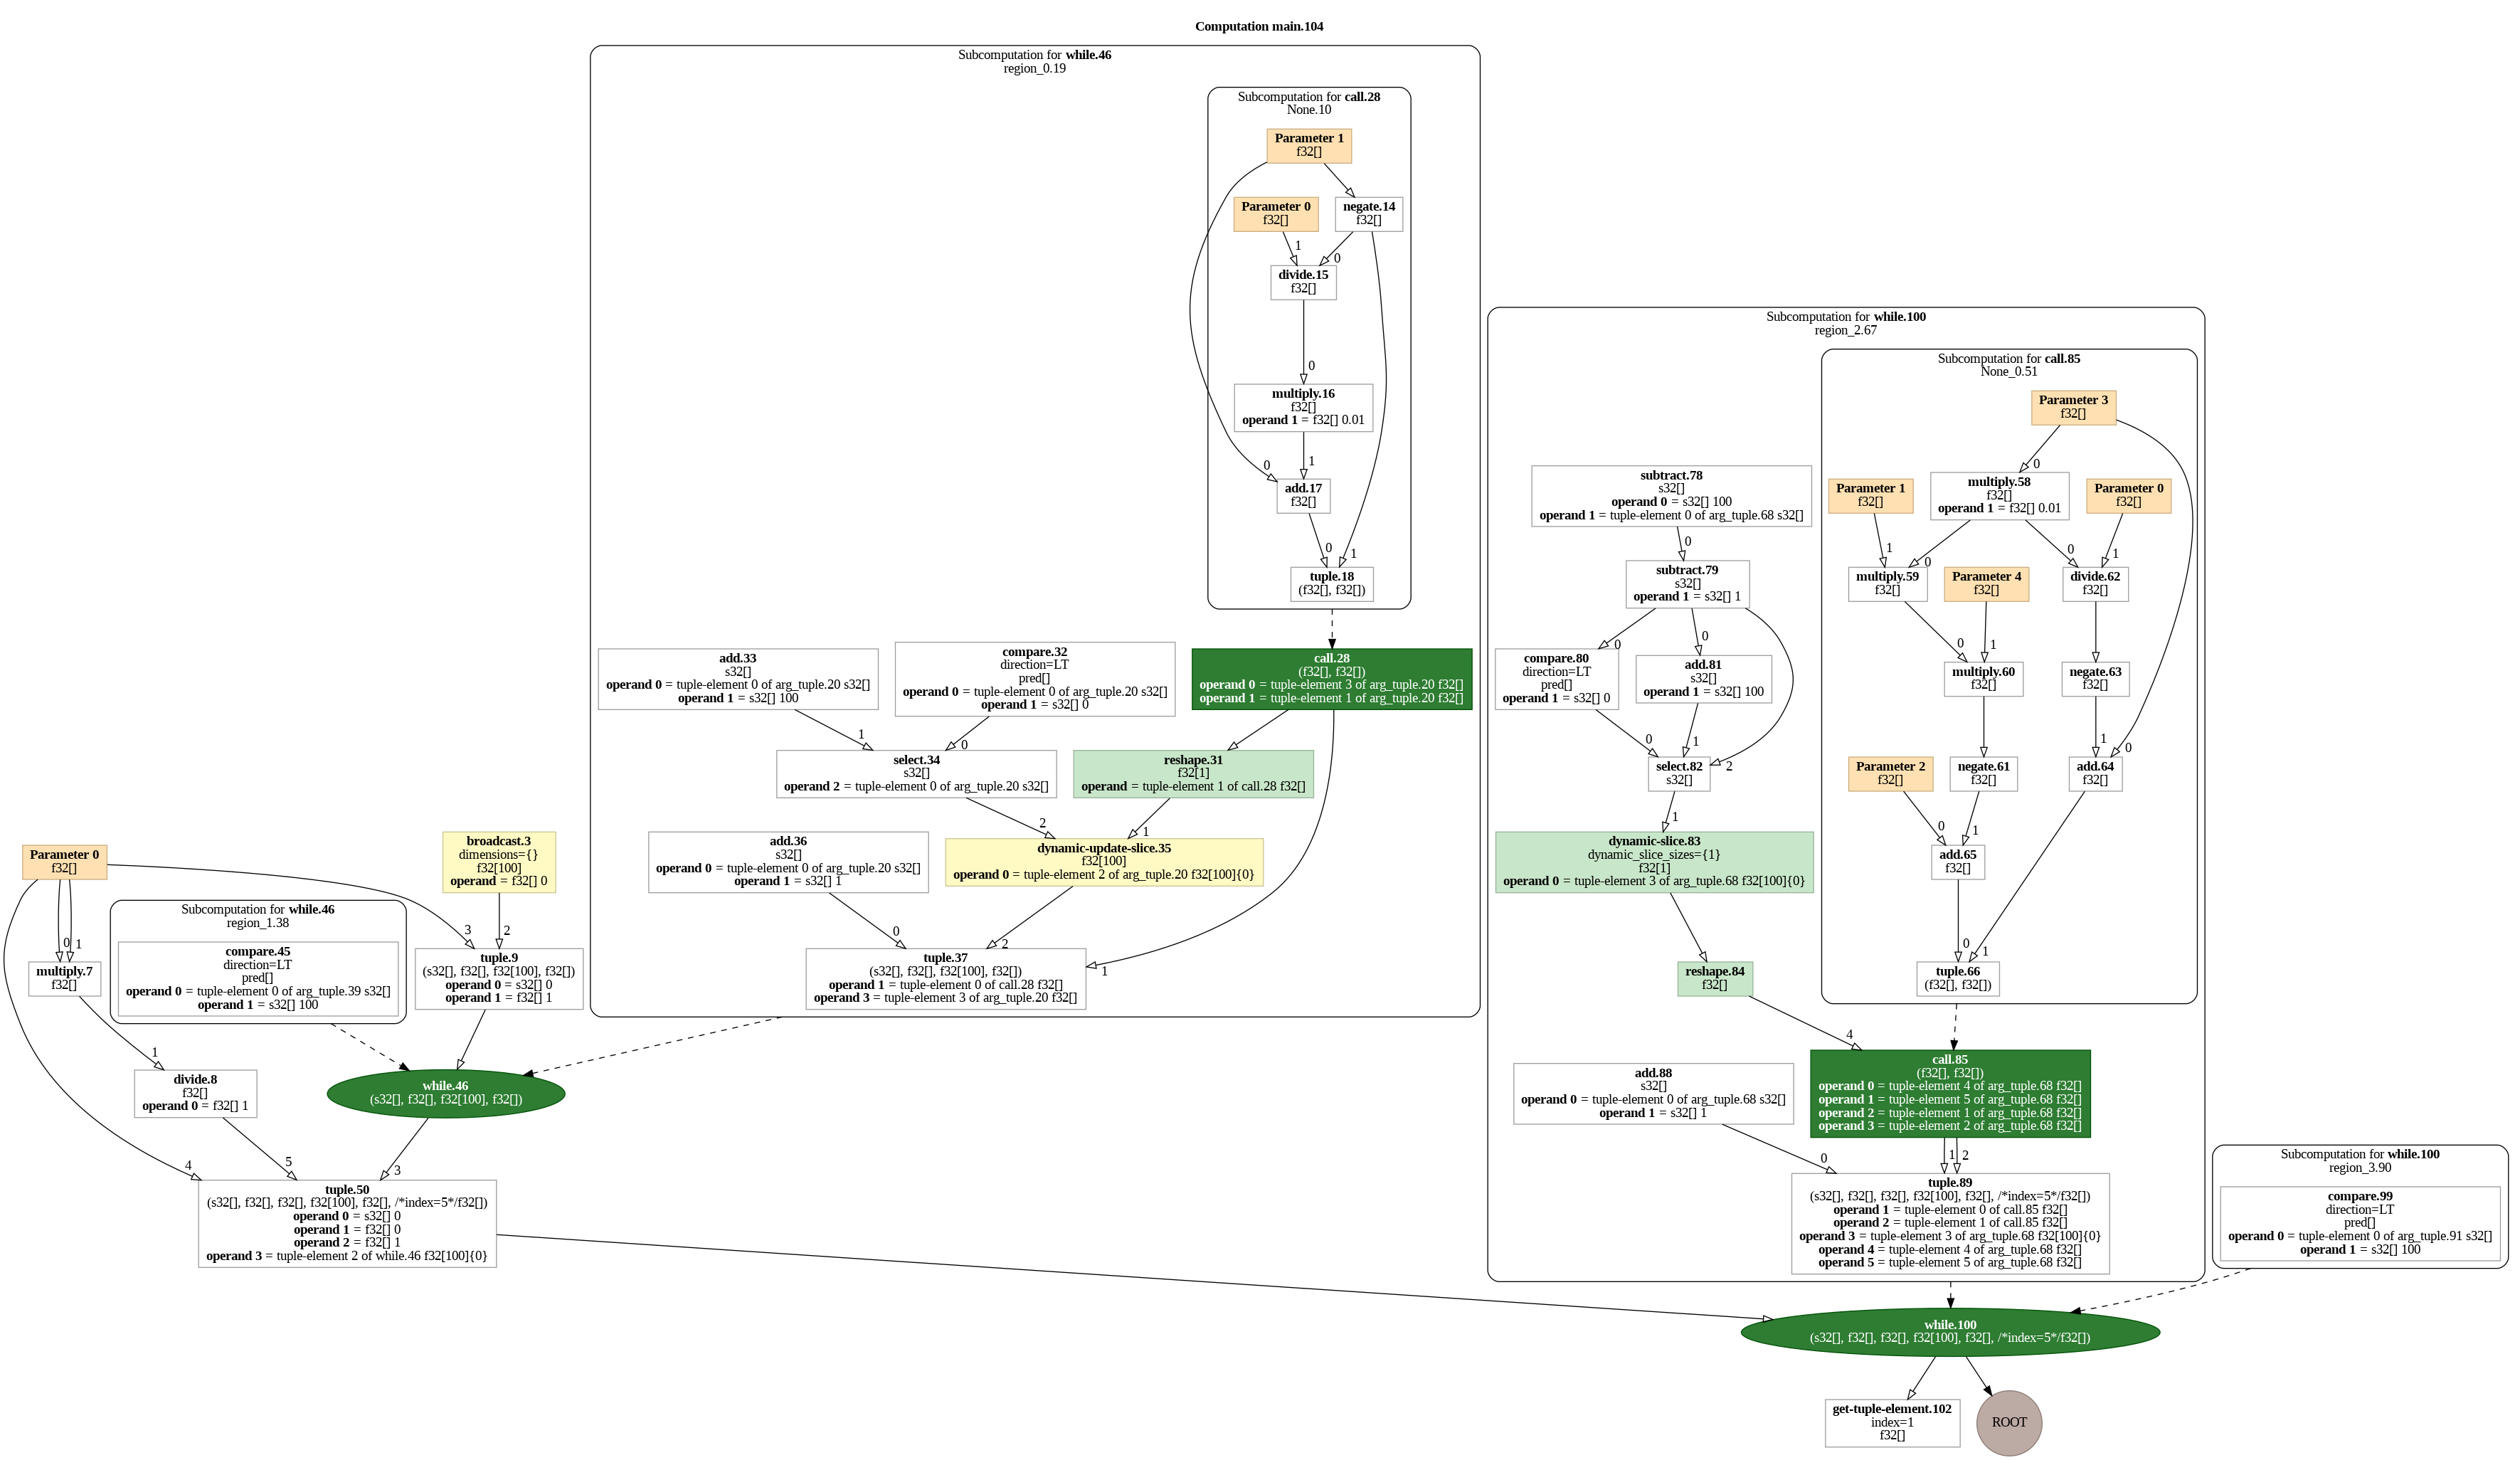

In [11]:
viz_computational_graph(grad_tau_fn,[tau],compiled=False)

# Part 2b

Here we will use AD to construct the adjoint equations themselves and then solve them numerically. We can then contrast these results with the AD derivative of the forward solution. In other words we will compare the 'optimise-then-discretise' and 'discretise-then-optimise' strategies.

Following Kidger's thesis, we form two adjoint equations using derivatives of the forward model. For a forward model of the form:

$$ \frac{dy}{dt} = f(t,y,\theta) $$

Where $\theta$ are our model parameters. In our case of the exponential decay there is only one parameter, $\tau$.

Given a loss function, $L$, that is a function of only the terminal value, $y(T)$, we have the following adjoint equations:

$$ \frac{d a_y}{dt} = - a_y \frac{\partial f}{\partial y} $$
$$ \frac{d a_\theta}{dt} = - a_y \frac{\partial f}{\partial \theta} $$

with the following initial conditions:

$$ a_y(T) = \frac{dL}{dy(T)} \ , \ a_\theta(T) = 0 $$

To find the gradients we need we must therefore solve the adjoint equations backwards in time. In this exercise we will use Euler's method for simplicity. The numerical system therefore looks like:

$$ [a_y^{j+1} \ , \ a_{\theta}^{j+1}] = \left[a_y^{j} \ , \ a_{\theta}^{j} \right] - dt \left[ -a_y^{j} \ \frac{\partial f}{\partial y}(t^{j},y^{j},\theta) \ , \ -a_y^{j} \  \frac{\partial f}{\partial \theta}(t^{j},y^{j},\theta) \right] $$

N.B. the index $j$ increases as we step backwards in time.

The following code is set up to solve this problem but there are a few functions to be completed

In [12]:
def init_cond(loss_fn,yT):
  """

  """
  dLdyT = jax.grad(loss_fn)(yT)
  return jnp.array([dLdyT,0.0])

def adjoint_forcing_term(t,a,args):
  """

  """
  f = jnp.zeros_like(a)
  dfdy = jax.grad(dydt,argnums=1)
  dfdtheta = jax.grad(dydt,argnums=2)
  y = get_y_value(t,args)
  f = f.at[0].set(-a[0]*dfdy(t,y,args))
  f = f.at[1].set(-a[0]*dfdtheta(t,y,args)['tau'])
  return f

def get_y_value(t,args):
  """
  A function to get the y value from the forward solution at time t

  Normally this would be obtained by an interpolation on the forward numerical solution

  We will slightly cheat here for the sake of simplicity and use the analytic result
  """
  return analytic_solution(args['y0'],t,args['tau'])

In [13]:
def backward_pass_explicit_Euler(y1,t0,t1,Nt,tau,loss_fn):
  dt = (t1-t0)/(Nt)
  args = {'tau' : tau, 'y0' : y0}
  a1 = init_cond(loss_fn,y1)
  # s array is (a,t)
  s1 = jnp.append(a1,t1)

  def _integrate(i,si):
    """
    Single time step using explicit Euler differencing
    """
    ai = si[:2]
    ti = si[2]
    aip1 = ai-adjoint_forcing_term(ti,ai,args)*dt
    sip1 = jnp.append(aip1,ti-dt)
    return sip1

  def _backward_pass():
    """
    Integrate ODE forward using for loop
    """
    s0 = jax.lax.fori_loop(0,Nt,_integrate,s1)
    return s0[:2],s0[2]

  return _backward_pass()

In [14]:
# N.B. Nt_adjoint does not need to equal the Nt used for the forward solution for 'optimise-then-discretise' approach
Nt_adjoint = 100

a0,t_end = backward_pass_explicit_Euler(y1,t0,t1,Nt_adjoint,tau,identity)

We can compare the accuracy of the two numerical approaches to computing an adjoint against the analytic solution.

In [15]:
print(f'Numerical "discretise-then-optimise" adjoint: {grad_tau_fn(tau)}, \nNumerical "optimise-then-discretise" adjoint: {a0[1]}, \nand analytic adjoint solution: {tau_adjoint_val}')

Numerical "discretise-then-optimise" adjoint: 0.5413049459457397, 
Numerical "optimise-then-discretise" adjoint: 0.5359453558921814, 
and analytic adjoint solution: 0.5413411259651184


Finally, we can compare the convergence behaviour of the two adjoint solution methods with respect to the number of Euler steps used in the integrators.

Text(0.5, 0, '# Euler steps')

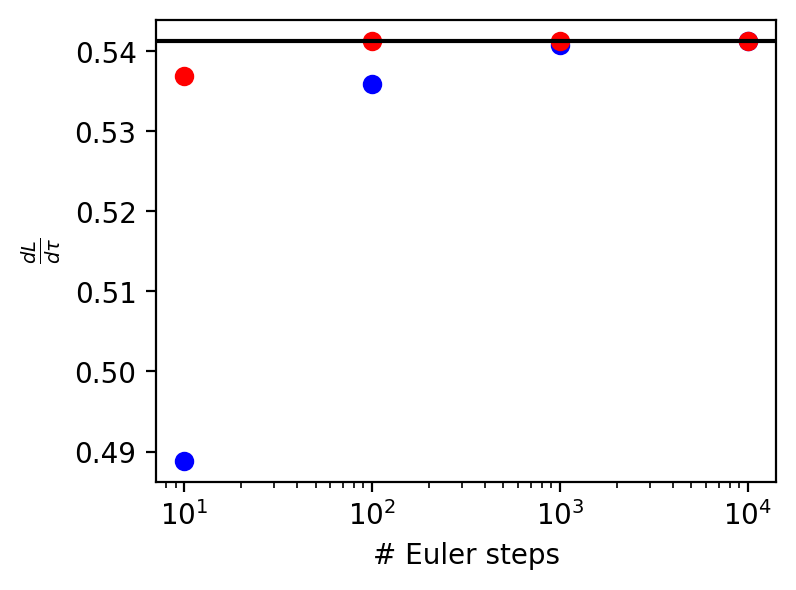

In [16]:
Nts = [10,100,1000,10000]

fig = plt.figure(dpi=200,figsize=(4,3))
ax1 = fig.add_subplot(111)

o2d_adjoint_fn = lambda x,N : backward_pass_explicit_Euler(y1,t0,t1,N,x,identity)[0][1]
d2o_adjoint_fn = lambda x,N : jax.grad(forward_pass_explicit_Euler,argnums=4,has_aux=True)(y0,t0,t1,N,x,identity)[0]

for Nt in Nts:
  ax1.plot(Nt,o2d_adjoint_fn(tau,Nt),'bo')
  ax1.plot(Nt,d2o_adjoint_fn(tau,Nt),'ro')

ax1.axhline(tau_adjoint_val,c='k')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\frac{dL}{d\tau}$')
ax1.set_xlabel("# Euler steps")

## Questions

1.   True or False: The discretise-then-optimise and optimise-then-discretise strategies for computing the adjoint involve a different number of loops.
2.   Which of the two strategies involves the AD propagating through a graph with a loop?
3.   Which of the two stategies would most easily allow a different time stepping scheme for the forward and adjoint computations?

# Exercise completed!

Key takeaways:

- Automatic Differentiation (AD) allows accurate computation of gradients of complex numerical functions. AD makes use of computational graphs to achieve this.
- The numerical solutions to differential equations are no different than other complex numerical functions. AD can be used to two ways to backpropagate gradients through differential equations:
  1. 'Discretise-then-optimise': One discretises the differential equation and writes a numerical integrator. AD traces through the graph of this numerical integrator to produce an adjoint solution.
  2. 'Optimise-then-discretise': One dicretises both the differential equation *and* its adjoint equations. AD can be used to compute the derivative terms that appear in the adjoint equations' forcing terms.
- AD therefore gives us a clear path towards differentiable simulators!